# Time-lag Analysis
Use pairs of channels from SDO/AIA to perform a time-lag analysis in every pixel of our simulated AR.

In [18]:
import os
import glob

import numpy as np
import scipy.signal
from scipy.interpolate import splev
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from sunpy.map import Map,GenericMap
from astropy.io import fits
import astropy.units as u

from synthesizAR.instruments import InstrumentSDOAIA

%matplotlib inline

In [2]:
root_template =  '/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_tn{freq}/SDO_AIA/{channel}/map_t{ti:06d}.fits'

In [3]:
aia_instr = InstrumentSDOAIA([0,2e4]*u.s)

In [4]:
temperature = np.logspace(4,8,1000)

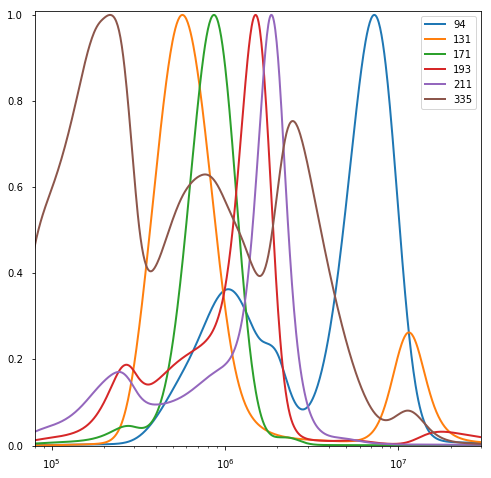

In [5]:
plt.figure(figsize=(8,8))
for channel in aia_instr.channels:
    tresp = splev(temperature,channel['temperature_response_spline'])
    plt.plot(temperature,tresp/np.max(tresp),label=channel['name'])
plt.xscale('log')
#plt.yscale('log')
plt.xlim([8e4,3e7])
#plt.ylim([1e-30,2e-24])
plt.ylim([0,1.01])
plt.legend()

## Data Aggregation

Choose a frequency and a set of channel pairs: one hotter and one cooler.

In [76]:
freq = 5000
hot_channel = 94
cool_channel = 335
starting_time = 7500*u.s
stopping_time = 12500*u.s
interval = np.arange(starting_time.value,stopping_time.value,aia_instr.cadence.value)

Setup cubes to read the slices in time into.

In [77]:
tmp = Map(root_template.format(freq=freq,channel=cool_channel,ti=750))

In [104]:
mapcubes = {}
for channel in aia_instr.channels:
    mapcubes[channel['name']] = np.empty(tmp.data.shape+interval.shape)

MemoryError: 

In [105]:
aia_instr.channels[0]['name']

'94'

Now, build up the datacubes.

In [79]:
for i,time in enumerate(interval):
    ti = np.where(aia_instr.observing_time.value==time)[0][0]
    print('t={}'.format(ti))
    with fits.open(root_template.format(freq=freq,channel=hot_channel,ti=ti),memmap=False) as hdus:
        hot_map = Map(hdus[0].data,hdus[0].header)
        hot_map_array[:,:,i] = hot_map.data
    with fits.open(root_template.format(freq=freq,channel=cool_channel,ti=ti),memmap=False) as hdus:
        cool_map = Map(hdus[0].data,hdus[0].header)
        cool_map_array[:,:,i] = cool_map.data

t=750
t=751
t=752
t=753
t=754
t=755
t=756
t=757
t=758
t=759
t=760
t=761
t=762
t=763
t=764
t=765
t=766
t=767
t=768
t=769
t=770
t=771
t=772
t=773
t=774
t=775
t=776
t=777
t=778
t=779
t=780
t=781
t=782
t=783
t=784
t=785
t=786
t=787
t=788
t=789
t=790
t=791
t=792
t=793
t=794
t=795
t=796
t=797
t=798
t=799
t=800
t=801
t=802
t=803
t=804
t=805
t=806
t=807
t=808
t=809
t=810
t=811
t=812
t=813
t=814
t=815
t=816
t=817
t=818
t=819
t=820
t=821
t=822
t=823
t=824
t=825
t=826
t=827
t=828
t=829
t=830
t=831
t=832
t=833
t=834
t=835
t=836
t=837
t=838
t=839
t=840
t=841
t=842
t=843
t=844
t=845
t=846
t=847
t=848
t=849
t=850
t=851
t=852
t=853
t=854
t=855
t=856
t=857
t=858
t=859
t=860
t=861
t=862
t=863
t=864
t=865
t=866
t=867
t=868
t=869
t=870
t=871
t=872
t=873
t=874
t=875
t=876
t=877
t=878
t=879
t=880
t=881
t=882
t=883
t=884
t=885
t=886
t=887
t=888
t=889
t=890
t=891
t=892
t=893
t=894
t=895
t=896
t=897
t=898
t=899
t=900
t=901
t=902
t=903
t=904
t=905
t=906
t=907
t=908
t=909
t=910
t=911
t=912
t=913
t=914
t=915
t=91

## Compute Correlations per Pixel

In [80]:
lags_tmp = np.arange(interval.shape[0])[1:]*np.diff(interval)
lags = np.hstack((-lags_tmp[::-1],np.array([0]),lags_tmp))
time_lags = np.empty(cool_map_array.shape[:-1])
max_correlations = np.empty(cool_map_array.shape[:-1])

Normalize the timeseries in each pixel

In [81]:
cool_map_max = np.max(cool_map_array,axis=2)[:,:,np.newaxis]
cool_map_array_norm = cool_map_array/np.where(cool_map_max==0.,1,cool_map_max)
hot_map_max = np.max(hot_map_array,axis=2)[:,:,np.newaxis]
hot_map_array_norm = hot_map_array/np.where(hot_map_max==0.,1,hot_map_max)

Compute the correlations.

In [82]:
for i in range(time_lags.shape[0]):
    for j in range(time_lags.shape[1]):
        corr = scipy.signal.correlate(hot_map_array_norm[i,j,:],cool_map_array_norm[i,j,:])
        time_lags[i,j] = lags[np.argmax(corr)]
        max_correlations[i,j] = np.max(corr)

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


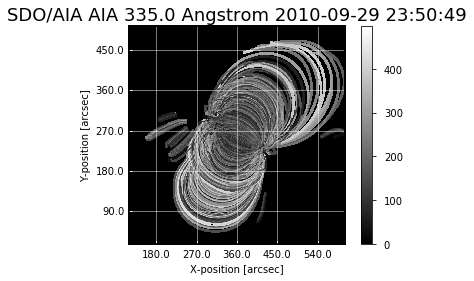

In [83]:
GenericMap(max_correlations,cool_map.meta).peek(
    #norm=matplotlib.colors.SymLogNorm(1,vmin=1e2,vmax=1e10)
)

In [84]:
time_lags_masked = np.where(max_correlations==0.,0.,-time_lags)

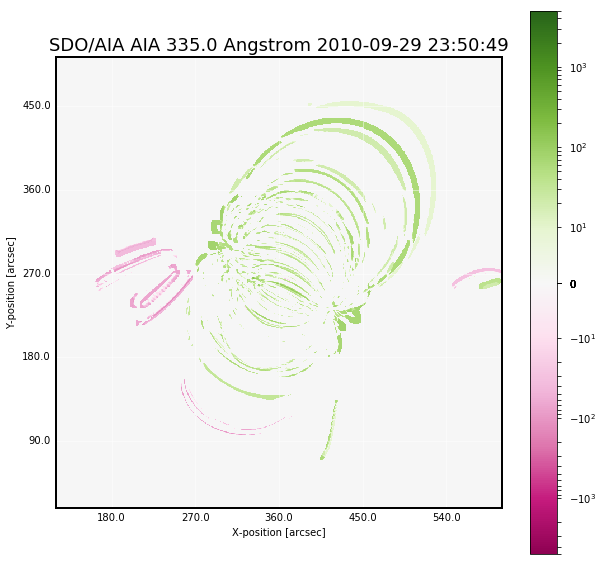

In [96]:
fig = plt.figure(figsize=(10,10))
im = GenericMap(time_lags_masked,cool_map.meta).plot(
    norm=matplotlib.colors.SymLogNorm(10,vmin=-5000,vmax=5000),
    cmap=plt.get_cmap('PiYG')
)
fig.colorbar(im)

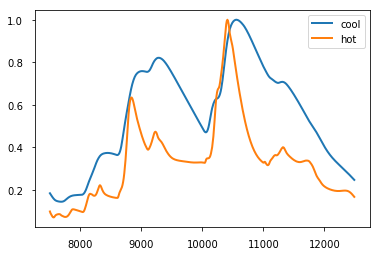

In [101]:
plt.plot(aia_instr.observing_time[750:1250],cool_map_array_norm[400,400,:],label='cool')
plt.plot(aia_instr.observing_time[750:1250],hot_map_array_norm[400,400,:],label='hot')
plt.legend()

In [102]:
test_corr = scipy.signal.correlate(cool_map_array_norm[400,400,:],hot_map_array_norm[400,400,:],mode='full')

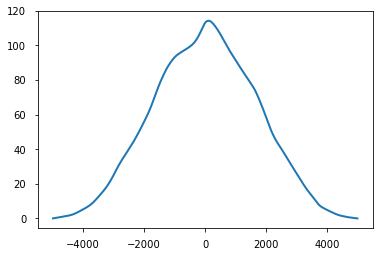

In [103]:
plt.plot(lags,test_corr)